<a href="https://colab.research.google.com/github/hejazn86/Stock_price_prediction/blob/main/stock_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Extracting Stock data from Yahoo API**

In [ ]:
#!pip install yfinance
import yfinance as yf

# Define the stock ticker and date range
ticker = 'AAPL'
start_date = '2014-01-01'
end_date = '2024-06-20'

# Fetch historical stock data of specific company (Apple)
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Save the data
stock_data.to_csv('stock_price.csv')
len(stock_data)

[*********************100%%**********************]  1 of 1 completed


2633

**Extracting Stock data using Alpha vantage API**

In [ ]:
# Install and load Alpha Vantage API
#!pip install alpha_vantage
#!pip install python-dotenv
#from alpha_vantage.timeseries import TimeSeries
#import pandas as pd

#from dotenv import load_dotenv
#import os

#load_dotenv()

# API key
#api_key = os.getenv('API_KEY')

# Initialize the TimeSeries class
#ts = TimeSeries(key=api_key, output_format='pandas')

# Get historical data for a given ticker
#ticker = 'AAPL'
#data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')

#data.to_csv('stock_vantage.csv')
#print(data.head())
#len(data)

**Data Processing and Feature Engineering**

In [ ]:
# Loading the data
import pandas as pd
import numpy as np

stock_data = pd.read_csv('stock_price.csv')

# check for missing values
stock_data.isnull().sum()

# Feature enginerring : extracting the year and the month
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)
stock_data['Year'] = stock_data.index.year
stock_data['Month'] = stock_data.index.month

# Calculate the Simple Moving average of the stocks
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean().fillna(method='bfill')
stock_data['SMA_100'] = stock_data['Close'].rolling(window=100).mean().fillna(method='bfill')

# Calculating The Exponential Moving Average
stock_data['EMA_10'] = stock_data['Close'].ewm(span= 10, adjust = False).mean().fillna(method='bfill')
stock_data['EMA_100'] = stock_data['Close'].ewm(span=100, adjust=False).mean().fillna(method='bfill')

# Calculate the Volatility (Annual)
#stock_data['Range'] = stock_data['High'] - stock_data['Low']
stock_data['Returns'] = stock_data['Close'].pct_change().fillna(method='bfill')
stock_data['Volatility'] = stock_data['Returns'].rolling(window = 10).std()* np.sqrt(252)
stock_data['Volatility'] = stock_data['Volatility'].fillna(method='bfill')
# Calculate Momentum Indicators: Relative Strength Index (RSI)
def RelativeStrengthIndex (series, period=14):
    delta = series.diff(1) # get the daily price change
    gain = delta.where(delta > 0, 0)                    # create a series with only the positive price changes
    loss = -delta.where(delta < 0, 0)                   # create a series with only the negative price changes
    avg_gain = gain.rolling(window=period).mean()       #calculate the moving average for the positive changes
    avg_loss = loss.rolling(window=period).mean()       # calculate the moving average for the negative changes
    retrnStr = avg_gain / avg_loss                      # calulate the relative strength
    retrnStridx = 100 - (100 / (1 + retrnStr))          # calculate the index
    return retrnStridx

stock_data['RSI_14'] = RelativeStrengthIndex(stock_data['Close']).fillna(method='bfill')


#  Calculate Momentum Indicators: Moving Average Convergence Divergence (MACD)
def MovingAverageConvergDiverg (series, shortPeriod=12, longPeriod=26, signalPeriod=9):
  seriesEMA12 = series.ewm(span=shortPeriod, adjust=False).mean()
  seriesEMA26 = series.ewm(span=longPeriod, adjust=False).mean()
  MACD = seriesEMA12 - seriesEMA26
  signalLine = MACD.ewm(span=signalPeriod, adjust=False).mean()
  return MACD, signalLine


MACD, SignalLine = MovingAverageConvergDiverg(stock_data['Close'])
stock_data['MACD'] = MACD
stock_data['SignalLine'] = SignalLine



**Exploratory Data Analysis (EDA)**

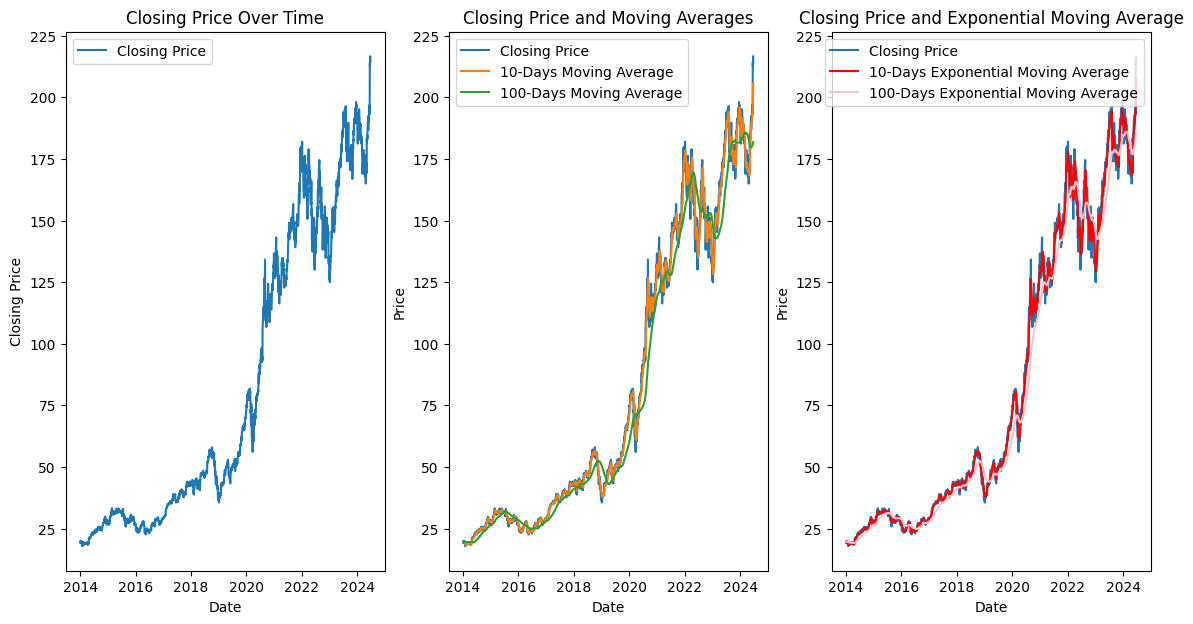

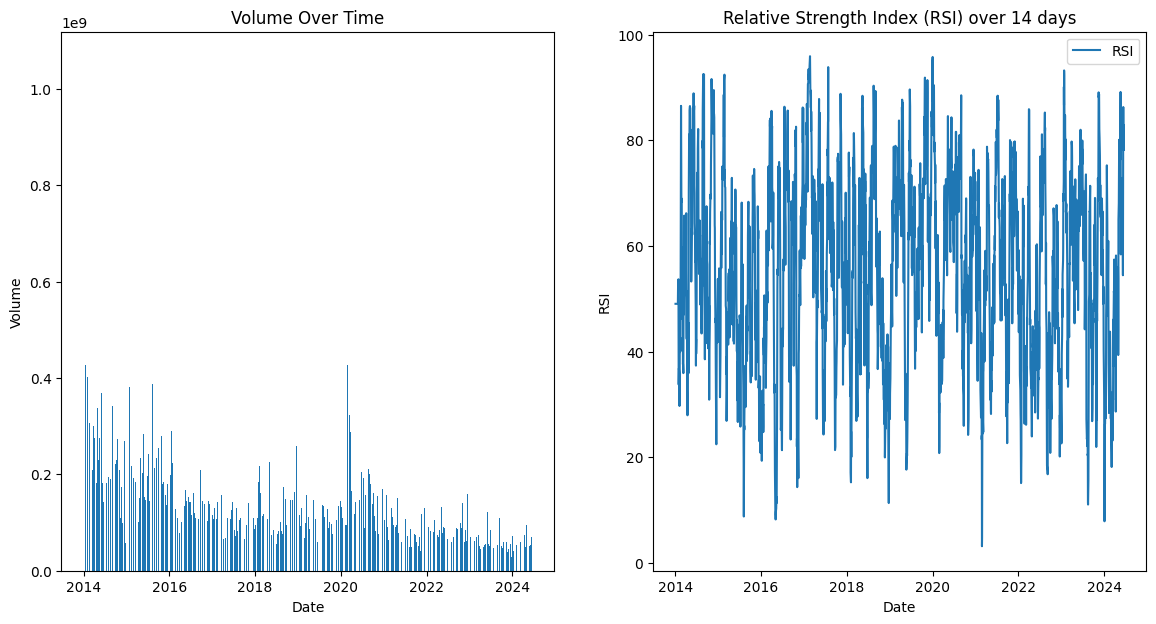

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
plt.plot(stock_data['Close'], label='Closing Price')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(stock_data['Close'], label='Closing Price')
plt.plot(stock_data['SMA_10'], label='10-Days Moving Average')
plt.plot(stock_data['SMA_100'], label='100-Days Moving Average')
plt.title('Closing Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(stock_data['Close'], label='Closing Price')
plt.plot(stock_data['EMA_10'], label='10-Days Exponential Moving Average', c='red')
plt.plot(stock_data['EMA_100'], label='100-Days Exponential Moving Average', c= 'pink')
plt.title('Closing Price and Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.bar(stock_data.index, stock_data['Volume'])
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')


plt.subplot(1, 2, 2)
plt.plot(stock_data['RSI_14'], label='RSI')
plt.title('Relative Strength Index (RSI) over 14 days')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# Plotting the closing prices
fig = px.line(stock_data, x=stock_data.index, y='Close', title='Closing Price Over Time', labels={'Close': 'Closing Price'})
fig.show()


# Plotting the closing prices and the moving averages
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Closing Price'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['SMA_10'], mode='lines', name='10-Days Moving Average'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['SMA_100'], mode='lines', name='100-Days Moving Average'))
fig.update_layout(title='Closing Price and Moving Averages', xaxis_title='Date', yaxis_title='Price')
fig.show()


# Plotting the closing prices and the Exponential moving averages
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Closing Price'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['EMA_10'], mode='lines', name='10-Days Exponential Moving Average'))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['EMA_100'], mode='lines', name='100-Days Exponential Moving Average'))
fig.update_layout(title='Closing Price and Exponential Moving Averages', xaxis_title='Date', yaxis_title='Price')
fig.show()


# Plotting the volume
fig = px.bar(stock_data, x=stock_data.index, y='Volume', title='Volume Over Time', labels={'Volume': 'Volume'})
fig.show()

# Plot RSI
fig = px.line(stock_data, x=stock_data.index, y=stock_data['RSI_14'], title='Relative Strength Index (RSI) over 14 days', labels={'RSI': 'RSI'})
fig.show()


***Summary Statistics and Correlation Analysis***

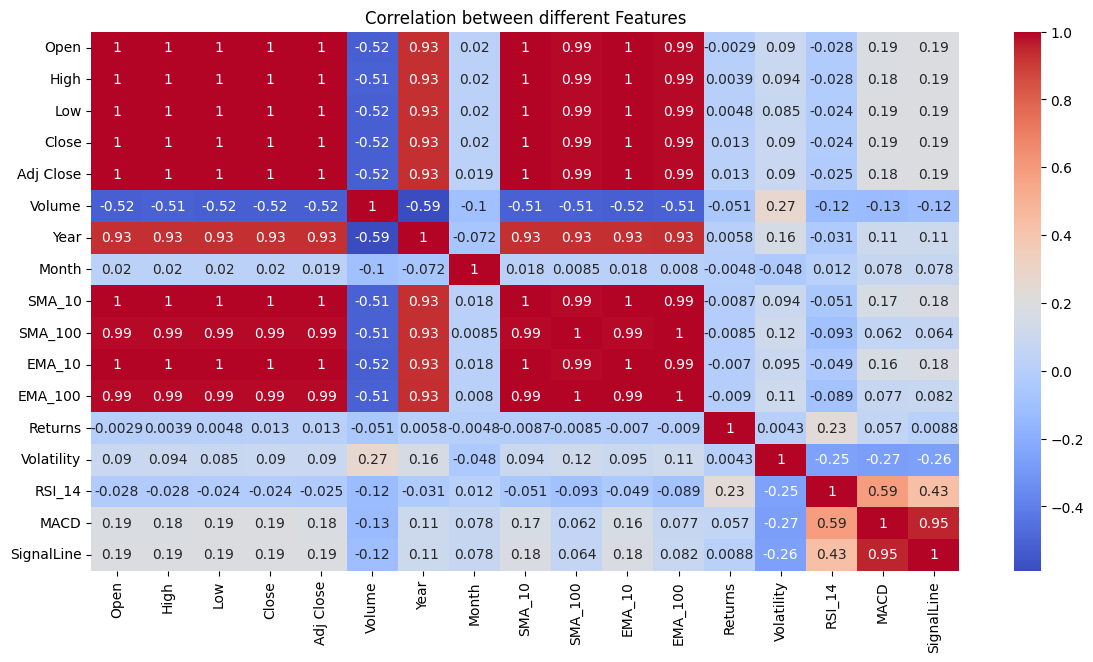

In [ ]:
# Summary statistics of the stock data
stock_data.describe()

# Correlation analysis
correlation_matrix = stock_data.corr()

plt.figure(figsize=(14, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between different Features')
plt.show()

**Bulding the Model**

In [88]:
# importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#split the data to train and test
data_train, data_test = train_test_split(stock_data, test_size=0.3, shuffle=False)
#np.isnan(data_train).any()
#np.isnan(data_test).any()

train_x = data_train.drop('Close', axis = 1)
train_y = data_train['Close']
test_x = data_test.drop('Close', axis = 1)
test_y = data_test['Close']

#train_x.shape
# test_x.shape


#Feature Scalling
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)


# Initialize and train the model
L_regressor = LinearRegression()
L_regressor.fit(train_x, train_y)

# Predict on the test data
pred_y = L_regressor.predict(test_x)


# Evaluating the Model results
mse = mean_squared_error(test_y, pred_y)

print(f'Mean Squared Error: {mse}')

r2 = r2_score(test_y, pred_y)
print(f'R^2 Score: {r2}')

# Plotting the results of Linear Regression model
results = pd.DataFrame({'Actual': test_y, 'Predicted': pred_y}, index= test_y.index)

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=results.index, y=results['Actual'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=results.index, y=results['Predicted'], mode='lines', name='Predicted'))

fig.update_layout(title='Actual vs Predicted Stock Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(x=0, y=1))

fig.show()

Mean Squared Error: 0.5693014406258877
R^2 Score: 0.9984909612673851
